In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Normalize function: Subtract mean and divide by standard deviation
def normalize(x):
    mean = np.mean(x, axis=(0, 1, 2), keepdims=True)  # Mean across height, width, and color channels
    std = np.std(x, axis=(0, 1, 2), keepdims=True)  # Standard deviation across height, width, and color channels
    return (x - mean) / (std + 1e-7)  # Adding small epsilon to avoid division by zero


In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data to [0, 1] range
x_train = normalize(x_train)
x_test = normalize(x_test)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
# Lowers learning rate if not improving for 3 epochs
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Stops early if not improving for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Residual network architecture
def residual_block(x, filters):
    skip = x

    # If the number of filters doesn't match, apply a 1x1 convolution
    if x.shape[-1] != filters:
        skip = layers.Conv2D(filters, (1, 1), strides=1, padding='same')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # Add input to convolutional outputs (makes it residual)
    x = layers.add([x, skip])

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [5]:
# Input layer
inputs = layers.Input(shape=(32, 32, 3))

# Initial Conv Layer
model_pipe = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
model_pipe = layers.BatchNormalization()(model_pipe)
model_pipe = layers.MaxPooling2D((2, 2))(model_pipe)

# Residual Layers, double filters each time
model_pipe = residual_block(model_pipe, 64)
model_pipe = layers.MaxPooling2D((2, 2))(model_pipe)

model_pipe = residual_block(model_pipe, 128)
model_pipe = layers.MaxPooling2D((2, 2))(model_pipe)

model_pipe = residual_block(model_pipe, 256)
model_pipe = layers.MaxPooling2D((2, 2))(model_pipe)

# Flatten output from Residual Layers for Fully Connected Layers
model_pipe = layers.Flatten()(model_pipe)

# Fully Connected Layers, use dropout to prevent overfitting
model_pipe = layers.Dense(256, activation='relu')(model_pipe)
model_pipe = layers.Dropout(0.5)(model_pipe)
model_pipe = layers.Dense(128, activation='relu')(model_pipe)
model_pipe = layers.Dropout(0.5)(model_pipe)

# Use softmax to create probabilities for each class
model_pipe = layers.Dense(10, activation='softmax')(model_pipe)

# Create model based on pipeline and inputs
model = models.Model(inputs, model_pipe)

# Compile model using categorical cross entropy due to multi-class classification task
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 128)      │          8,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 8, 8, 128)      │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 128)      │            512 │ add_1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,504,970 (5.74 MB)

 Trainable params: 1,504,010 (5.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.2066 - loss: 2.2857 - val_accuracy: 0.4696 - val_loss: 1.5247 - learning_rate: 1.0000e-04
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4127 - loss: 1.6263 - val_accuracy: 0.5706 - val_loss: 1.2275 - learning_rate: 1.0000e-04
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5125 - loss: 1.3693 - val_accuracy: 0.6009 - val_loss: 1.1276 - learning_rate: 1.0000e-04
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5741 - loss: 1.2005 - val_accuracy: 0.6275 - val_loss: 1.0672 - learning_rate: 1.0000e-04
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6270 - loss: 1.0727 - val_accuracy: 0.5895 - val_loss: 1.2441 - learning_rate: 1.0000e-04
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6697 - loss: 0.9616 - val_accuracy: 0.6785 - val_loss: 0.9145 - learning_rate: 1.0000e-04
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - 

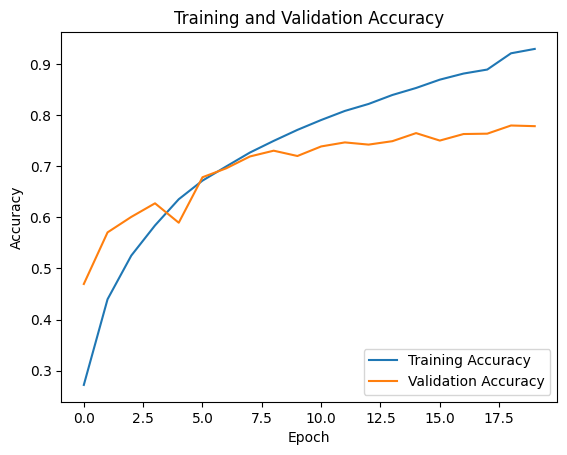

In [6]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, lr_schedule])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()